<a href="https://colab.research.google.com/github/Siba-mangal/Brain_tumor_detection/blob/using-keras/brain_tumor_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from os import listdir
from tensorflow.keras import datasets
import os


%matplotlib inline

In [3]:
def load_data(dir_list, image_size):
# load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '/' + filename)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image.astype('float32')
            image = image / 255.0
            X.append(image)
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [4]:
path = '/content/drive/MyDrive/dataset'
yes = path + '/yes' 
no = path + '/no'

IMG_WIDTH, IMG_HEIGHT = (256, 256)

X, y = load_data([yes, no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 1464
X shape is: (1464, 256, 256, 3)
y shape is: (1464, 1)


In [5]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.20,random_state = 42)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.20)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.20)

In [7]:
X_train.shape, y_train.shape ,X_val.shape, y_val.shape, X_test.shape, y_test.shape 

((1171, 256, 256, 3),
 (1171, 1),
 (59, 256, 256, 3),
 (59, 1),
 (234, 256, 256, 3),
 (234, 1))

In [8]:
#build model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout,ZeroPadding2D
from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

In [59]:
input_shape = (256,256,3)
model = Sequential()
model.add(ZeroPadding2D(padding=(2, 2), input_shape=input_shape))
model.add(Conv2D(filters = 64,kernel_size = (3,3),strides=(1,1),padding="same",activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2)))
# model.add(Conv2D(filters = 64,kernel_size = (3,3),strides=(1,1),padding="same",activation = 'relu'))
# model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2)))
model.add(Conv2D(filters = 128,kernel_size = (3,3),strides=(1,1),padding="same",activation = 'relu'))
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2)))
# model.add(Dropout(0.25))
model.add(Conv2D(filters = 256,kernel_size = (3,3),strides=(1,1),padding="same",activation = 'relu'))
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2)))
# model.add(Dropout(0.25))
model.add(Conv2D(filters = 512,kernel_size = (3,3),strides=(1,1),padding="same",activation = 'relu'))
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2)))
model.add(Dropout(0.20))
model.add(Flatten())
# model.add(Dense(32,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(10,activation='sigmoid'))

In [60]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_7 (ZeroPaddi  (None, 260, 260, 3)      0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 260, 260, 64)      1792      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 129, 129, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 129, 129, 128)     73856     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                            
                                                      

In [61]:
from tensorflow.keras.optimizers import Adam
learning_rate = 0.001
optimizer = Adam(learning_rate = learning_rate)

model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [62]:
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
37/37 [==============================] - 23s 328ms/step - loss: 0.8233 - accuracy: 0.6755 - val_loss: 0.5836 - val_accuracy: 0.6780
Epoch 2/50
37/37 [==============================] - 7s 189ms/step - loss: 0.4874 - accuracy: 0.7771 - val_loss: 0.5103 - val_accuracy: 0.7458
Epoch 3/50
37/37 [==============================] - 7s 184ms/step - loss: 0.4284 - accuracy: 0.8190 - val_loss: 0.4629 - val_accuracy: 0.8305
Epoch 4/50
37/37 [==============================] - 7s 187ms/step - loss: 0.3734 - accuracy: 0.8437 - val_loss: 0.4773 - val_accuracy: 0.7119
Epoch 5/50
37/37 [==============================] - 7s 185ms/step - loss: 0.3404 - accuracy: 0.8634 - val_loss: 0.3133 - val_accuracy: 0.8475
Epoch 6/50
37/37 [==============================] - 7s 186ms/step - loss: 0.2735 - accuracy: 0.8933 - val_loss: 0.3348 - val_accuracy: 0.8305
Epoch 7/50
37/37 [==============================] - 7s 184ms/step - loss: 0.2343 - accuracy: 0.9035 - val_loss: 0.2557 - val_accuracy: 0.8644
Epoch

In [63]:
history = model.history.history
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [64]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

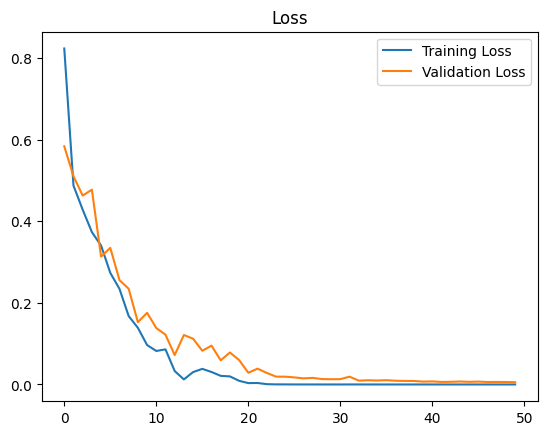

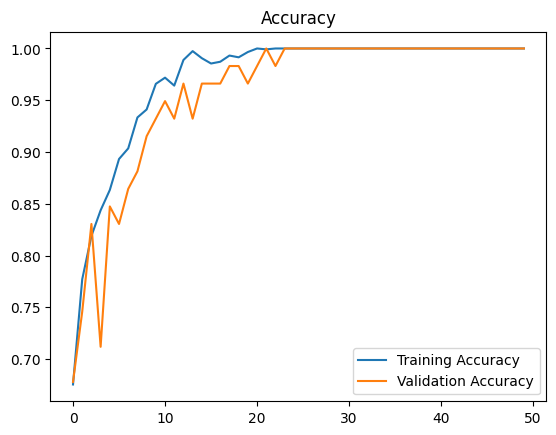

In [65]:
plot_metrics(history)

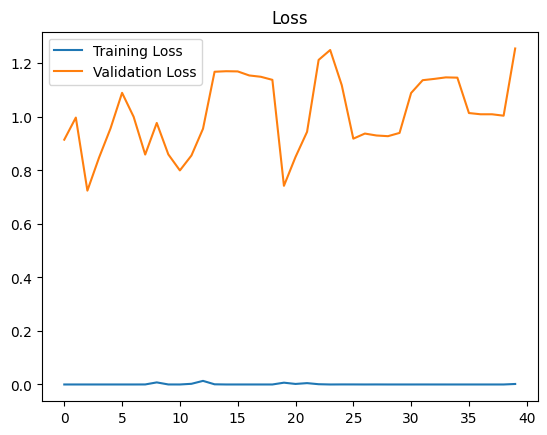

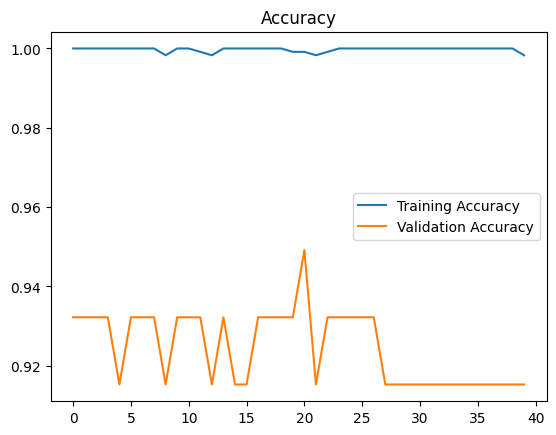

In [ ]:
plot_metrics(history)#learig_rate = 0.002 ad eochs = 40 batch size = 32

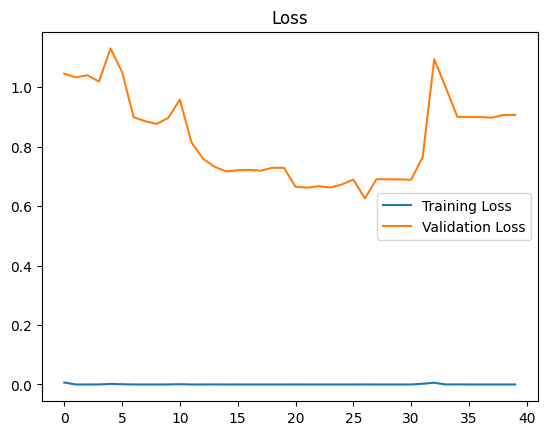

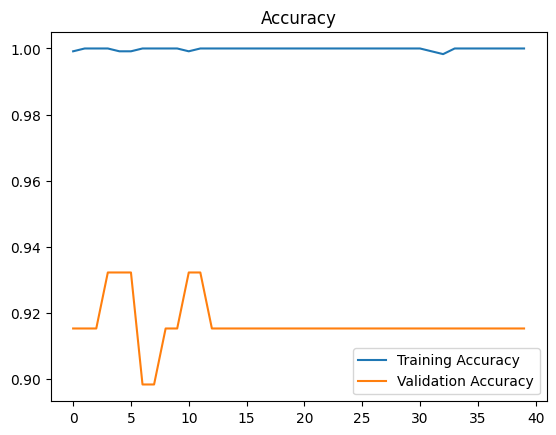

In [ ]:
plot_metrics(history)#learig_rate = 0.001 ad eochs = 40 batch size = 32

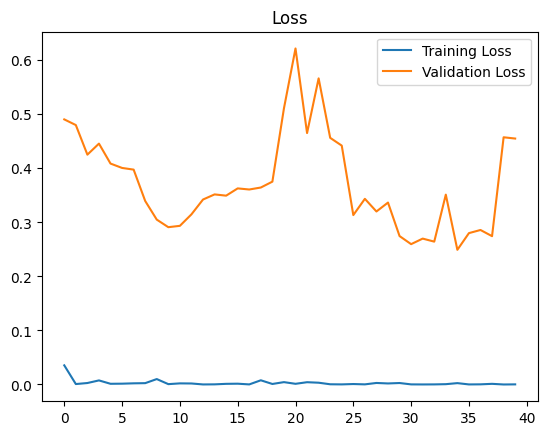

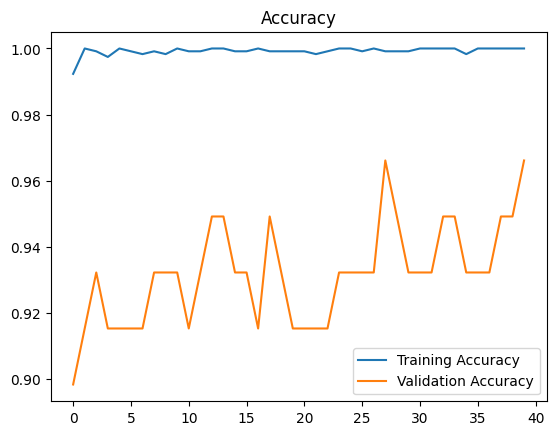

In [ ]:
plot_metrics(history)#learig_rate = 0.004 ad eochs = 40 batch size = 64

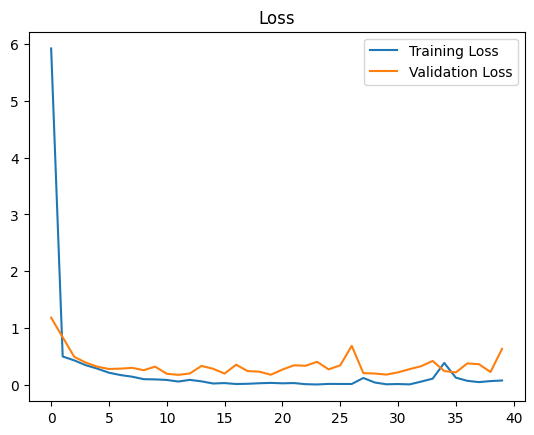

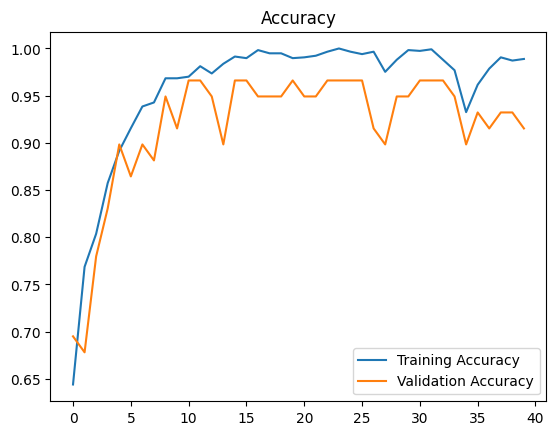

In [ ]:
plot_metrics(history)#learig_rate = 0.01 ad eochs = 40 batch_size = 32

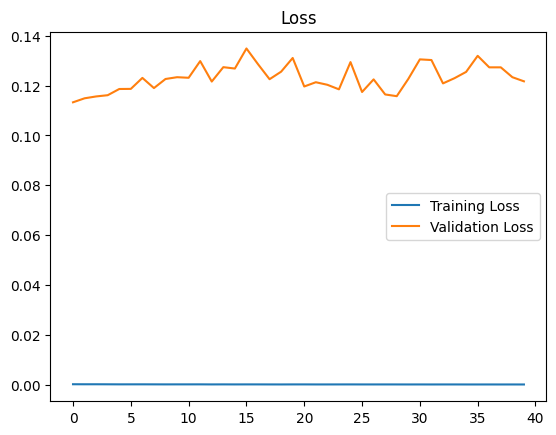

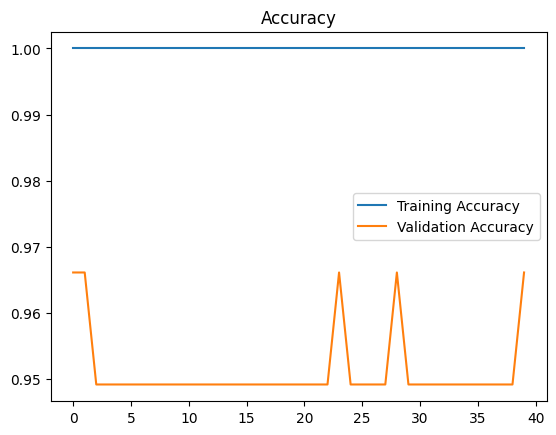

In [ ]:
plot_metrics(history)#learig_rate = 0.001 ad eochs = 40

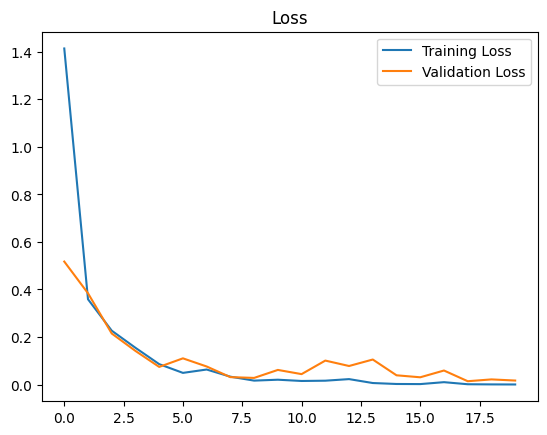

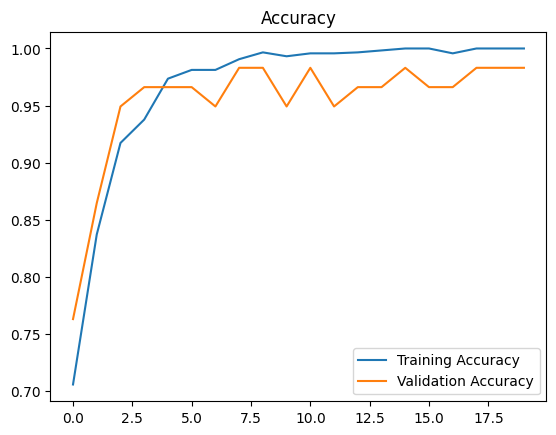

In [ ]:
plot_metrics(history)

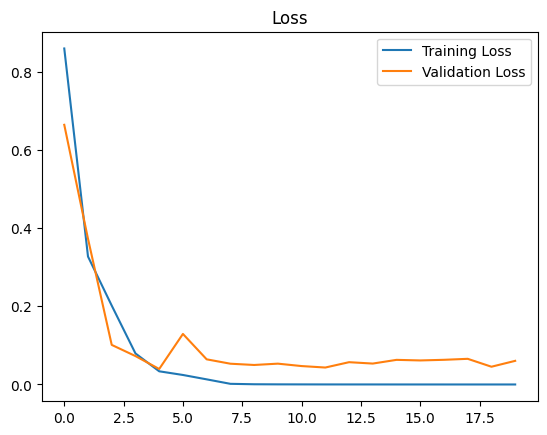

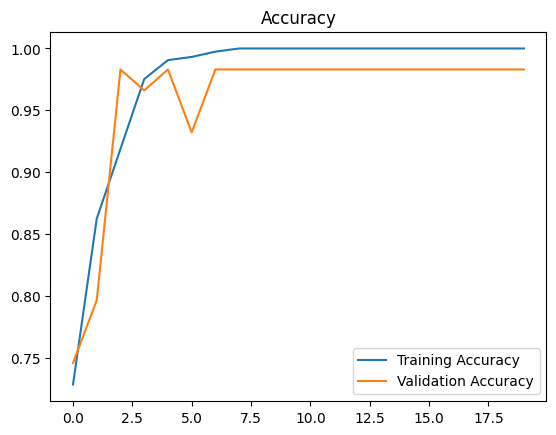

In [ ]:
plot_metrics(history)

In [ ]:
loss, acc = model.evaluate(x=X_test, y=y_test)

8/8 [==============================] - 1s 65ms/step - loss: 0.3402 - accuracy: 0.9487


In [ ]:
y_test_prob = model.predict(X_test)

8/8 [==============================] - 0s 32ms/step


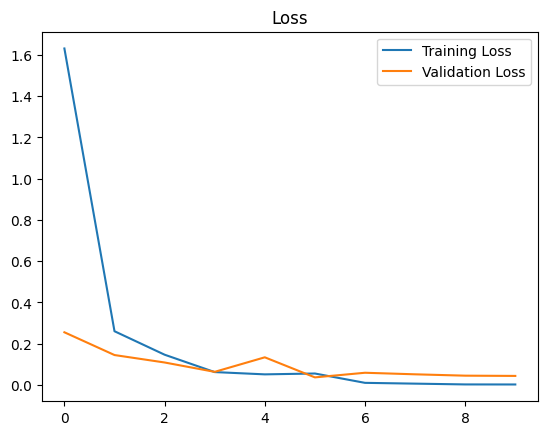

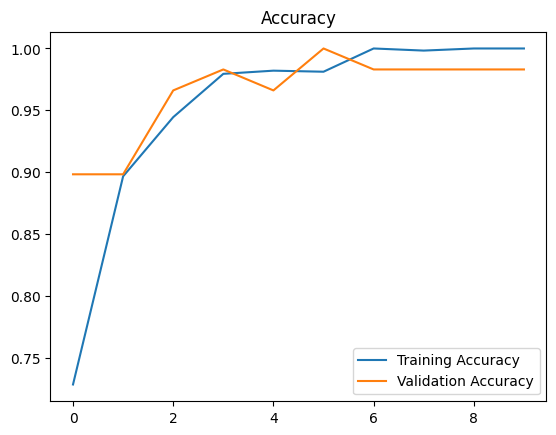

In [ ]:
plot_metrics(history)# 64 last layer

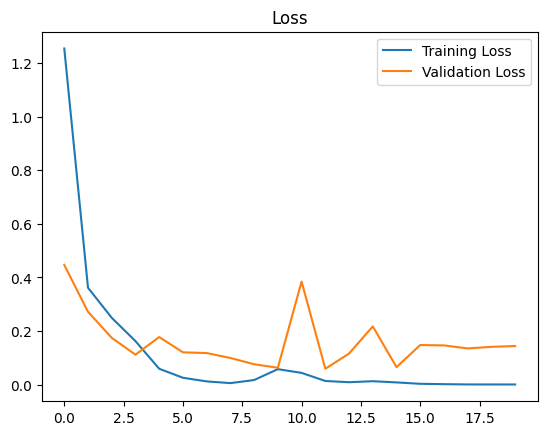

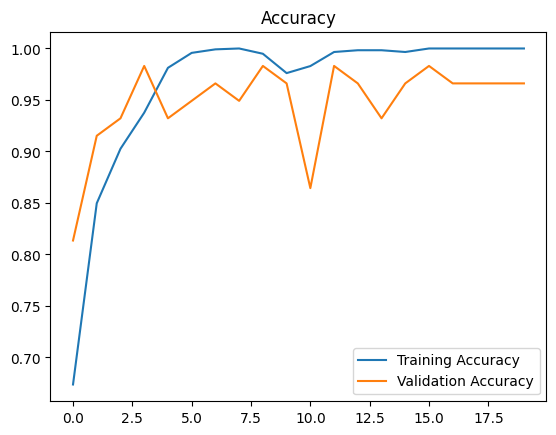

In [ ]:
plot_metrics(history)

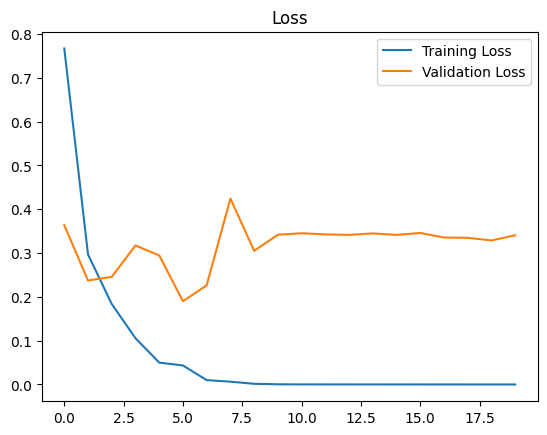

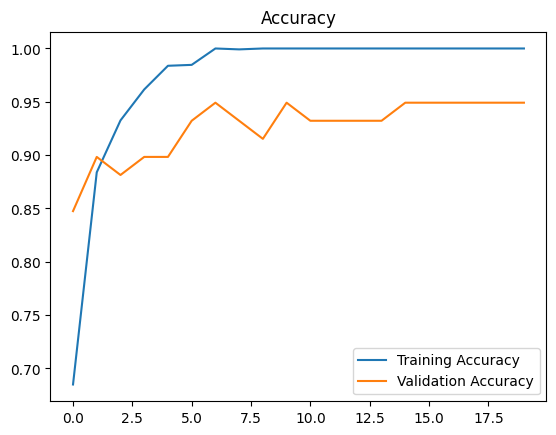

In [ ]:
#1st iteration over fetting
plot_metrics(history)

In [ ]:
test_loss, test_acc = model.evaluate(X_test,y_test,verbose=2)
print(test_acc)
print(test_loss)